https://adventofcode.com/2022/day/12

You ask the device for a heightmap of the surrounding area (your puzzle input). The heightmap shows the local area from above broken into a grid; the elevation of each square of the grid is given by a single lowercase letter, where a is the lowest elevation, b is the next-lowest, and so on up to the highest elevation, z.

Also included on the heightmap are marks for your current position (S) and the location that should get the best signal (E). 

You'd like to reach E, but to save energy, you should do it in as few steps as possible. During each step, you can move exactly one square up, down, left, or right. To avoid needing to get out your climbing gear, the elevation of the destination square can be at most one higher than the elevation of your current square; that is, if your current elevation is m, you could step to elevation n, but not to elevation o. (This also means that the elevation of the destination square can be much lower than the elevation of your current square.)

In the above diagram, the symbols indicate whether the path exits each square moving up (^), down (v), left (<), or right (>). The location that should get the best signal is still E, and . marks unvisited squares.

This path reaches the goal in 31 steps, the fewest possible.

What is the fewest steps required to move from your current position to the location that should get the best signal?

## My first approach: get out the crayon...

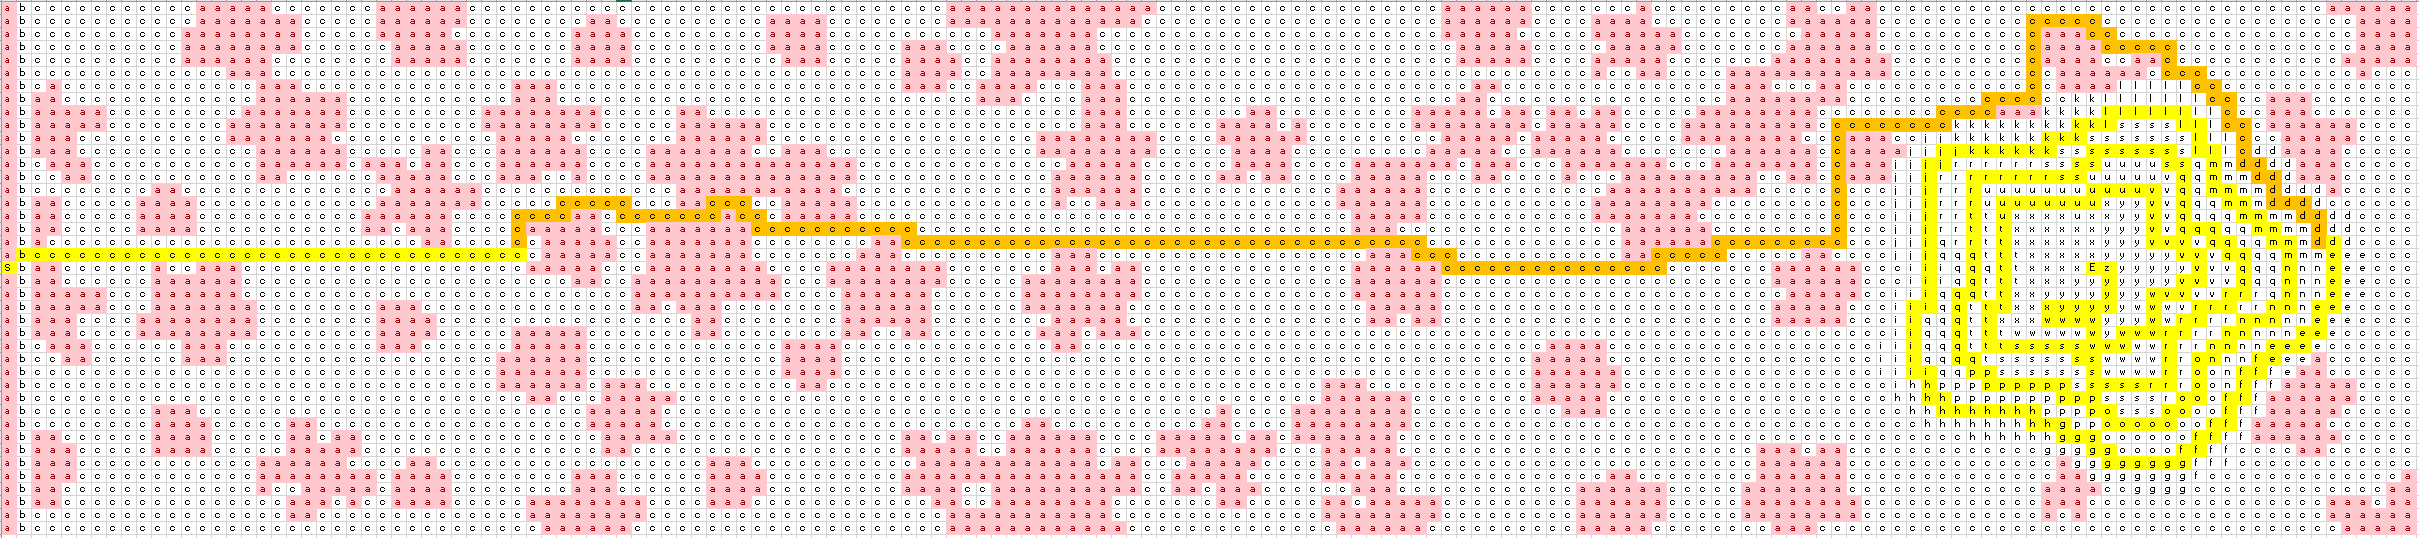

I counted 483 steps, which was too high. Let's try a graphing library with shortest path algorithms.

## A more methodical approach

I found the following articles helpful:
* https://python-course.eu/applications-python/graphs-python.php (doesn't address directed graphs, which we have)
* https://towardsdatascience.com/a-self-learners-guide-to-shortest-path-algorithms-with-implementations-in-python-a084f60f43dc

Here's a list of suggested graphing libraries: https://wiki.python.org/moin/PythonGraphLibraries. Let's start with python-igraph for its purported ease of use.

The graph can be generated from a list of lists or tuples that express the edges, the connections between nodes.  https://igraph.readthedocs.io/en/stable/generation.html#from-nodes-and-edges:
![image.png](attachment:image.png)

In [ ]:
import numpy as np

import igraph as ig

In [20]:
with open('elevation.txt', 'r') as f:
    heightmap = f.read().split('\n')

In [21]:
# or use example input

puzzle='''Sabqponm
abcryxxl
accszExk
acctuvwj
abdefghi'''

heightmap = puzzle.split('\n')

Because the map is a grid, it seems intuitive (and may be faster) to use matrix arithmetic for the calculations. So first, create an array with numeric values of elevation.

In [22]:
h = []

for row in heightmap:
    r = []
    for h_alpha in row:
        h_num = 'SabcdefghijklmnopqrstuvwxyzE'.index(h_alpha)
        r.append(h_num)
    h.append(r)
    
hn = np.array(h)
hn
        

array([[ 0,  1,  2, 17, 16, 15, 14, 13],
       [ 1,  2,  3, 18, 25, 24, 24, 12],
       [ 1,  3,  3, 19, 26, 27, 24, 11],
       [ 1,  3,  3, 20, 21, 22, 23, 10],
       [ 1,  2,  4,  5,  6,  7,  8,  9]])

Next, identify the arcs (directed edges between nodes). Is travel possible from each square to the right, left, up, or down? To calculate this I'll shift the elevation map one square in each direction, and subtract to find the difference. Elevation gain must be less than +1.

For example, consider moves to the right. We shift the map to the left to compare the destination to the current location. The right column is filled with a high value, to block travel beyond the end of the map.

In [23]:
destmap = np.roll(hn, -1, axis=1)
destmap[:, hn.shape[1]-1] = 99

destmap

array([[ 1,  2, 17, 16, 15, 14, 13, 99],
       [ 2,  3, 18, 25, 24, 24, 12, 99],
       [ 3,  3, 19, 26, 27, 24, 11, 99],
       [ 3,  3, 20, 21, 22, 23, 10, 99],
       [ 2,  4,  5,  6,  7,  8,  9, 99]])

If the increase in height is +1 level or less, you can move to the right.

In [24]:
arc = (destmap - hn <= 1)
arc

array([[ True,  True, False,  True,  True,  True,  True, False],
       [ True,  True, False, False,  True,  True,  True, False],
       [False,  True, False, False,  True,  True,  True, False],
       [False,  True, False,  True,  True,  True,  True, False],
       [ True, False,  True,  True,  True,  True,  True, False]])

Notice that impossible moves are excluded, like from position 2 to 3 in the top row (elevation b to q), or from the right column past the edge of the map. 

We need to determine the edges in all directions, and store them in a list that we can read with python-igraph.

In [25]:
def find_edges(hmap, direction):
    '''Determine, for each square, whether you can travel in a certain direction'''   
    edges = []
    srcnodes = np.array([i for i in range(hmap.size)])
    
    if direction == 'right':
        destmap = np.roll(hmap, -1, axis=1)
        destmap[:, hmap.shape[1]-1] = 99
        destnodes = srcnodes + 1
    elif direction == 'left':
        destmap = np.roll(hmap, 1, axis=1)
        destmap[:, 0] = 99
        destnodes = srcnodes - 1
    elif direction == 'up':
        destmap = np.roll(hmap, 1, axis=0)
        destmap[0, :] = 99
        destnodes = srcnodes - hmap.shape[1]
    elif direction == 'down':
        destmap = np.roll(hmap, -1, axis=0)
        destmap[hmap.shape[0]-1, :] = 99
        destnodes = srcnodes + hmap.shape[1]

    allowed = (destmap - hmap <= 1)
    attempt = [(srcnodes[node], destnodes[node]) for node in range(hmap.size)]
    for i in np.where(allowed.flatten())[0].tolist():
        edges.append(attempt[i])
    return edges

In [32]:
edges = []
edges.extend(find_edges(hn, 'right'))
edges.extend(find_edges(hn, 'down'))
edges.extend(find_edges(hn, 'left'))
edges.extend(find_edges(hn, 'up'))
edges

[(0, 1),
 (1, 2),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (8, 9),
 (9, 10),
 (12, 13),
 (13, 14),
 (14, 15),
 (17, 18),
 (20, 21),
 (21, 22),
 (22, 23),
 (25, 26),
 (27, 28),
 (28, 29),
 (29, 30),
 (30, 31),
 (32, 33),
 (34, 35),
 (35, 36),
 (36, 37),
 (37, 38),
 (38, 39),
 (0, 8),
 (1, 9),
 (2, 10),
 (3, 11),
 (7, 15),
 (8, 16),
 (9, 17),
 (10, 18),
 (11, 19),
 (12, 20),
 (14, 22),
 (15, 23),
 (16, 24),
 (17, 25),
 (18, 26),
 (19, 27),
 (20, 28),
 (21, 29),
 (22, 30),
 (23, 31),
 (24, 32),
 (25, 33),
 (26, 34),
 (27, 35),
 (28, 36),
 (29, 37),
 (30, 38),
 (31, 39),
 (1, 0),
 (2, 1),
 (3, 2),
 (4, 3),
 (5, 4),
 (6, 5),
 (7, 6),
 (9, 8),
 (10, 9),
 (11, 10),
 (12, 11),
 (13, 12),
 (14, 13),
 (17, 16),
 (18, 17),
 (19, 18),
 (20, 19),
 (21, 20),
 (25, 24),
 (26, 25),
 (27, 26),
 (28, 27),
 (29, 28),
 (30, 29),
 (33, 32),
 (34, 33),
 (35, 34),
 (36, 35),
 (37, 36),
 (38, 37),
 (39, 38),
 (8, 0),
 (9, 1),
 (10, 2),
 (11, 3),
 (12, 4),
 (13, 5),
 (14, 6),
 (15, 7),
 (16, 8),
 (17, 9),
 (18, 10

OK, Finally. Let the magic begin.  https://igraph.readthedocs.io/en/stable/tutorials/shortest_path_visualisation.html

In [33]:
g = ig.Graph(edges, directed=True)

In [34]:
print(g.summary(verbosity=1))

IGRAPH D--- 40 111 -- 
+ edges:
 0 ->  1  8
 1 ->  0  2  9
 2 ->  1 10
 3 ->  2  4 11
 4 ->  3  5
 5 ->  4  6
 6 ->  5  7
 7 ->  6 15
 8 ->  0  9 16
 9 ->  1  8 10 17
10 ->  2  9 18
11 ->  3 10 19
12 ->  4 11 13 20
13 ->  5 12 14
14 ->  6 13 15 22
15 ->  7 23
16 ->  8 24
17 ->  9 16 18 25
18 -> 10 17 26
19 -> 11 18 27
20 -> 12 19 21 28
21 -> 13 20 22 29
22 -> 14 23 30
23 -> 15 31
24 -> 16 32
25 -> 17 24 26 33
26 -> 18 25 34
27 -> 19 26 28 35
28 -> 27 29 36
29 -> 28 30 37
30 -> 22 29 31 38
31 -> 23 39
32 -> 24 33
33 -> 25 32
34 -> 26 33 35
35 -> 34 36
36 -> 35 37
37 -> 36 38
38 -> 37 39
39 -> 31 38


Seems reasonable

In [35]:
# Start, S
np.where(hn.flatten() == 0)[0][0]

0

In [36]:
# Target, E
np.where(hn.flatten() == 27)[0][0]

21

In [37]:
results = g.get_shortest_paths(np.where(hn.flatten() == 0)[0][0], to=np.where(hn.flatten() == 27)[0][0], output="vpath")

path = len(results[0]) - 1
path

31

For the puzzle input, I got the same answer that I got by hand. I submitted it again and it was still wrong. I considered that maybe since S is at level a and E is at level z, you could subtract 2 steps. That answer is 481. It was accepted, but it's inconsistent with the example where 31 steps are counted. So either I am reading something incorrectly or there is something strange with this problem.